# Deep Belief Networks

In [17]:
from colorama import Fore

import torch
import torch.nn as nn

from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [18]:
# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [19]:
# Define a single layer of the Deep Belief Network (as a Restricted Boltzmann Machine)
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hid, n_vis) * 0.1)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hid))

    def forward(self, v):
        # Forward pass - calculate the probabilities of hidden units given visible units
        p_h_given_v = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return p_h_given_v

In [20]:
# Define the Deep Belief Network
class DBN(nn.Module):
    def __init__(self, n_vis, hidden_layers, n_out):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList(
            [
                RBM(
                    n_vis if i == 0 else hidden_layers[i-1],
                    h
                )
                for i, h in enumerate(hidden_layers)
            ]
        )# Additional layer to map back to original input size
        self.output_layer = nn.Linear(hidden_layers[-1], n_out)

    def forward(self, v):
        for rbm in self.rbms:
            v = rbm(v)
        v = self.output_layer(v)
        return torch.sigmoid(v)

In [21]:
# MNIST dataset loading with transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
dbn = DBN(n_vis=784, hidden_layers=[500, 200, 50], n_out=784)

In [23]:
# Training loop
def train(dbn, train_loader, epochs, learning_rate, device):
    dbn.to(device)  # Transfer the model to GPU
    optimizer = torch.optim.Adam(dbn.parameters(), lr=learning_rate)
    loss_function = nn.BCELoss()

    dbn.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, _ in train_loader:
            data = data.view(-1, 784).to(device)  # Reshape and transfer data to GPU
            optimizer.zero_grad()
            output = dbn(data)
            loss = loss_function(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {Fore.CYAN}{epoch + 1}{Fore.RESET}, Loss: {Fore.GREEN}{total_loss / len(train_loader)}{Fore.RESET}')

In [24]:
def train_and_evaluate(dbn, train_loader, test_loader, epochs, learning_rate, device):
    dbn.to(device)
    optimizer = torch.optim.Adam(dbn.parameters(), lr=learning_rate)
    loss_function = nn.BCELoss()

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        dbn.train()
        total_loss = 0
        for data, _ in train_loader:
            data = data.view(-1, 784).to(device)
            optimizer.zero_grad()
            output = dbn(data)
            loss = loss_function(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Test the model
        dbn.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.view(-1, 784).to(device)
                output = dbn(data)
                test_loss += loss_function(output, data).item()

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f'Epoch {Fore.CYAN}{epoch + 1}{Fore.RESET}, Train Loss: {Fore.GREEN}{avg_train_loss}{Fore.RESET}, Test Loss: {Fore.YELLOW}{avg_test_loss}{Fore.RESET}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1, Train Loss: 0.27751217342452456, Test Loss: 0.2631073041706328
Epoch 2, Train Loss: 0.24847679764731354, Test Loss: 0.21272047101312383
Epoch 3, Train Loss: 0.18478261418878905, Test Loss: 0.16247928588633326
Epoch 4, Train Loss: 0.15109393418407135, Test Loss: 0.13951371444068897
Epoch 5, Train Loss: 0.13370246769014452, Test Loss: 0.12620490253161473
Epoch 6, Train Loss: 0.12271644259248969, Test Loss: 0.11727073238154126
Epoch 7, Train Loss: 0.11489822346963353, Test Loss: 0.11046432290866876
Epoch 8, Train Loss: 0.10911068376670005, Test Loss: 0.1056891575835313
Epoch 9, Train Loss: 0.10467025361208519, Test Loss: 0.10193318807205577
Epoch 10, Train Loss: 0.10116219623828493, Test Loss: 0.09878115669177596


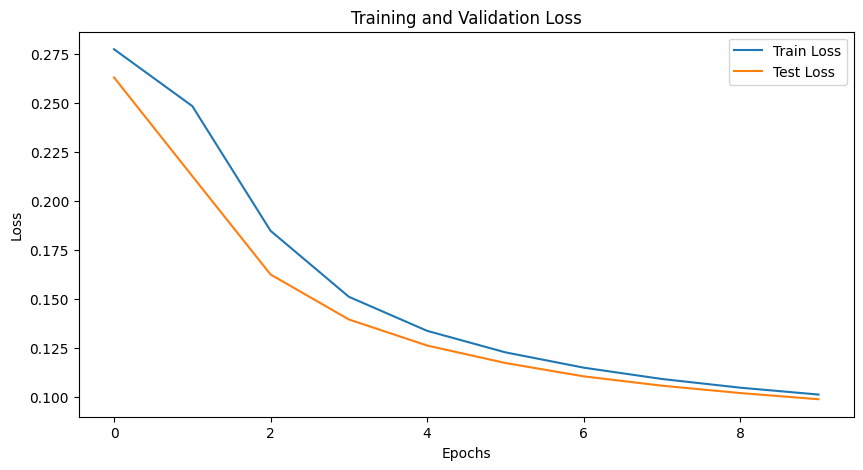

In [25]:
# train(dbn, train_loader, epochs=10, learning_rate=0.001, device=device)
train_and_evaluate(dbn, train_loader, test_loader, epochs=10, learning_rate=0.001, device=device)

In [26]:
def test(dbn, test_loader, device):
    dbn.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, 784).to(device)
            output = dbn(data)
            test_loss += nn.BCELoss()(output, data).item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {Fore.GREEN}{test_loss}{Fore.RESET}')

In [27]:
test(dbn, test_loader, device)

Test Loss: 0.09878115669177596


In [34]:
def visualize_reconstructions(dbn, test_loader, device, num_images=10):
    dbn.eval()
    test_data_iter = iter(test_loader)
    images, _ = next(test_data_iter)
    images = images.view(-1, 784).to(device)

    # Get the output from the model
    with torch.no_grad():
        reconstructed = dbn(images).cpu()  # Move to CPU for plotting

    images = images.cpu()  # Also move the original images to CPU

    fig, axs = plt.subplots(2, num_images, figsize=(15, 3))
    for i in range(num_images):
        # Original Images
        axs[0, i].imshow(images[i].view(28, 28), cmap='gray')
        axs[0, i].set_title('Original')
        axs[0, i].axis('off')

        # Reconstructed Images
        axs[1, i].imshow(reconstructed[i].view(28, 28), cmap='gray')
        axs[1, i].set_title('Reconstructed')
        axs[1, i].axis('off')

    plt.show()

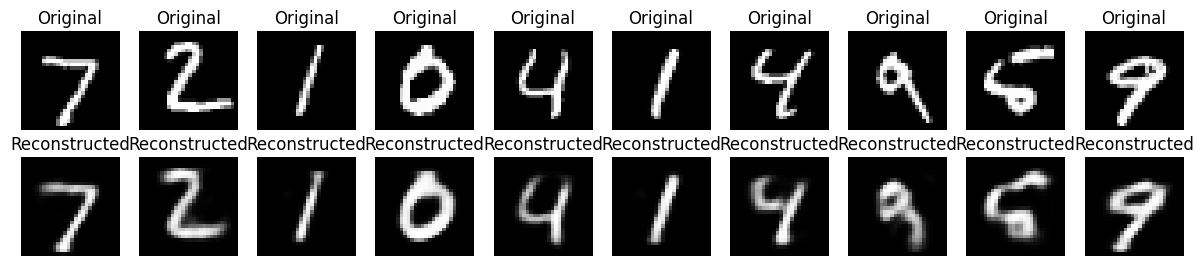

In [35]:
visualize_reconstructions(dbn, test_loader, device)